In [ ]:
!rm -rf dl-projects
!git clone https://github.com/mengwangk/dl-projects
!cd dl-projects && ls 

!pip install featuretools==0.11.0

In [ ]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
%matplotlib inline

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from pathlib import Path



In [ ]:
# DATASET = Path("datasets/lotto/data_processed_2.csv")

DATASET = Path("dl-projects/datasets/lotto/data_processed.csv")

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [ ]:
# Read into data frame
dataset = pd.read_csv(DATASET, header=0, sep=',', quotechar='"', parse_dates=['DrawDate'], dtype={'PrizeType': str})

In [ ]:
df = dataset.copy()

In [7]:
columns = ['DrawNo', 'DrawDate', 'PrizeType', 'LuckyNo']
df = df[columns]
print(df.shape)
df.head(10)

(104673, 4)


,DrawNo,DrawDate,PrizeType,LuckyNo
0,40792,1992-05-06,1stPrizeNo,19
1,40792,1992-05-06,2ndPrizeNo,1124
2,40792,1992-05-06,3rdPrizeNo,592
3,40792,1992-05-06,ConsolationNo1,5311
4,40792,1992-05-06,ConsolationNo10,407
5,40792,1992-05-06,ConsolationNo2,1949
6,40792,1992-05-06,ConsolationNo3,1606
7,40792,1992-05-06,ConsolationNo4,3775
8,40792,1992-05-06,ConsolationNo5,6226
9,40792,1992-05-06,ConsolationNo6,1271


In [ ]:
#df['LuckyNo'].value_counts().plot.bar(figsize=(6,5))

In [ ]:
# df.groupby(['LuckyNo']).max().head(10)

In [ ]:
# df.groupby(['LuckyNo']).count().tail(10)

In [ ]:
df.rename(columns={"DrawNo": "draw_no", "DrawDate": "draw_date", "PrizeType": "prize_type", "LuckyNo": "lucky_no" }, inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104673 entries, 0 to 104672
Data columns (total 4 columns):
draw_no       104673 non-null int64
draw_date     104673 non-null datetime64[ns]
prize_type    104673 non-null object
lucky_no      104673 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.2+ MB


In [ ]:
df['number_id'] = df.groupby(['lucky_no']).ngroup()

In [14]:
df.loc[lambda df: df['number_id'] == 0000]

,draw_no,draw_date,prize_type,lucky_no,number_id
11686,91595,1995-08-02,3rdPrizeNo,0,0
21541,134398,1998-04-26,SpecialNo1,0,0
23100,141198,1998-10-01,ConsolationNo5,0,0
30430,173000,2000-09-09,2ndPrizeNo,0,0
48346,251005,2005-06-04,1stPrizeNo,0,0
56190,285107,2007-06-06,2ndPrizeNo,0,0
79783,387613,2013-05-04,SpecialNo6,0,0
81258,394013,2013-09-14,SpecialNo9,0,0
82908,401214,2014-02-08,SpecialNo3,0,0
85712,413414,2014-10-18,SpecialNo10,0,0


In [15]:
df = df[["number_id", "draw_no", "draw_date", "prize_type", "lucky_no"]]
df.head(3)

,number_id,draw_no,draw_date,prize_type,lucky_no
0,19,40792,1992-05-06,1stPrizeNo,19
1,1124,40792,1992-05-06,2ndPrizeNo,1124
2,592,40792,1992-05-06,3rdPrizeNo,592


## Making Labels

In [ ]:
def make_cutoffs(draw_date):
  all_numbers = df[df['draw_date'] <= draw_date]['number_id'].unique()
  matched_numbers = df[df['draw_date'] == draw_date]['number_id'].unique()
  df_all = pd.DataFrame({'number_id': all_numbers, 'lucky_no': all_numbers})
  df_all['label'] = (df_all['number_id'].isin(matched_numbers)).astype(int)
  
  # The cutoff time is the draw_date
  df_all['cutoff_time'] = pd.to_datetime(draw_date)
  df_all = df_all[['number_id', 'cutoff_time', 'lucky_no', 'label']]
  return df_all     

number_id      22
cutoff_time    22
lucky_no       22
label          22
dtype: int64

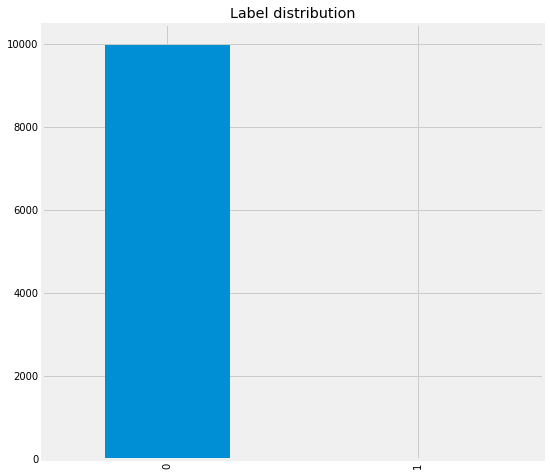

In [17]:
  df_draw = make_cutoffs(pd.datetime(2014, 1, 4))
  plt.figure(figsize=(8,8))
  df_draw['label'].value_counts().plot.bar();
  plt.title('Label distribution')
  df_draw.loc[df_draw['label'] ==1].count()

In [18]:
df.loc[df['draw_date'] == pd.datetime(2014,1,4)].sort_values(['lucky_no'])

,number_id,draw_no,draw_date,prize_type,lucky_no
82482,598,399414,2014-01-04,ConsolationNo10,598
82490,925,399414,2014-01-04,ConsolationNo9,925
82478,963,399414,2014-01-04,1stPrizeNo,963
82484,1486,399414,2014-01-04,ConsolationNo3,1486
82483,1556,399414,2014-01-04,ConsolationNo2,1556
82499,3348,399414,2014-01-04,SpecialNo8,3348
82491,3693,399414,2014-01-04,SpecialNo1,3693
82485,4225,399414,2014-01-04,ConsolationNo4,4225
82480,4761,399414,2014-01-04,3rdPrizeNo,4761
82494,4776,399414,2014-01-04,SpecialNo3,4776


In [19]:
df.loc[df['draw_date'].dt.year <= 2014]['lucky_no'].nunique()

9999

In [ ]:
# Start year to generate the labels
START_YEAR = 2014

# labels = pd.DataFrame()
# for dt in df.loc[df['draw_date'].dt.year >= START_YEAR]['draw_date'].unique():
#   df_draw = make_cutoffs(dt)
#   if labels.empty:
#     labels = df_draw
#   else:
#     labels = pd.concat([labels, df_draw], axis=0)
#   #print(dt, labels.shape, len(labels.loc[labels['label'] == 1]))


# print(labels.shape, len(labels.loc[labels['label'] == 1]))
# labels.to_csv('labels.csv', index=False)

In [ ]:
# !tar cvf labels.tar labels.csv 
# !gzip labels.tar

In [ ]:
# from google.colab import files
# files.download('labels.tar.gz')

In [ ]:
labels = pd.read_csv('dl-projects/datasets/lotto/labels.tar.gz', compression="gzip", header=0, sep=',', quotechar='"', parse_dates=['cutoff_time'], )

In [24]:
labels.shape

(9659595, 4)

In [25]:
labels.rename(columns={"labels.csv": "number_id"}, inplace=True)
labels.head(10)

,number_id,cutoff_time,lucky_no,label
0,19.0,2014-01-01,19.0,0.0
1,1124.0,2014-01-01,1124.0,0.0
2,592.0,2014-01-01,592.0,0.0
3,5311.0,2014-01-01,5311.0,0.0
4,407.0,2014-01-01,407.0,0.0
5,1949.0,2014-01-01,1949.0,0.0
6,1606.0,2014-01-01,1606.0,0.0
7,3775.0,2014-01-01,3775.0,0.0
8,6226.0,2014-01-01,6226.0,0.0
9,1271.0,2014-01-01,1271.0,0.0


In [26]:
labels.describe()

,number_id,lucky_no,label
count,9.659594e+06,9.659594e+06,9.659594e+06
mean,4.999413e+03,4.999413e+03,2.297405e-03
std,2.886751e+03,2.886751e+03,4.787617e-02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.499000e+03,2.499000e+03,0.000000e+00
50%,4.999000e+03,4.999000e+03,0.000000e+00
75%,7.499000e+03,7.499000e+03,0.000000e+00
max,9.999000e+03,9.999000e+03,1.000000e+00


In [27]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9659595 entries, 0 to 9659594
Data columns (total 4 columns):
number_id      float64
cutoff_time    datetime64[ns]
lucky_no       float64
label          float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 294.8 MB


## Skewness of data

In [ ]:
#  https://github.com/mengwangk/Automated-Manual-Comparison/blob/master/Retail%20Spending/notebooks/Automated%20Retail%20Spending.ipynb

In [ ]:
def ecdf(data):
    """
    Empirical cumulative distribution function (ECDF) plot
    """
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

In [ ]:
# d = df['LuckyNo'].astype(str)

In [ ]:
# x, y = ecdf(d)
# plt.plot(x, y, marker = '.')
# plt.xlabel('Lucky No'); plt.ylabel('Percentile'); plt.title('ECDF of Lucky No');

### Generate new features

In [ ]:
#df = df.reset_index()

In [33]:
#df.rename(columns={"index": "instance_id"}, inplace=True)
df.head(10)

,number_id,draw_no,draw_date,prize_type,lucky_no
0,19,40792,1992-05-06,1stPrizeNo,19
1,1124,40792,1992-05-06,2ndPrizeNo,1124
2,592,40792,1992-05-06,3rdPrizeNo,592
3,5311,40792,1992-05-06,ConsolationNo1,5311
4,407,40792,1992-05-06,ConsolationNo10,407
5,1949,40792,1992-05-06,ConsolationNo2,1949
6,1606,40792,1992-05-06,ConsolationNo3,1606
7,3775,40792,1992-05-06,ConsolationNo4,3775
8,6226,40792,1992-05-06,ConsolationNo5,6226
9,1271,40792,1992-05-06,ConsolationNo6,1271


In [ ]:
es = ft.EntitySet(id="Results")

In [35]:
# Add the entire data table as an entity
es.entity_from_dataframe("results",
                         dataframe=df,
                         index="results_index",
                         time_index = 'draw_date')

es['results']

2019-10-14 07:06:33,882 featuretools.entityset - WARNING    index results_index not found in dataframe, creating new integer column


Entity: results
  Variables:
    results_index (dtype: index)
    number_id (dtype: numeric)
    draw_no (dtype: numeric)
    draw_date (dtype: datetime_time_index)
    prize_type (dtype: categorical)
    lucky_no (dtype: numeric)
  Shape:
    (Rows: 104673, Columns: 6)

In [36]:
# Create a new entity
es.normalize_entity(new_entity_id="numbers",
                    base_entity_id="results",
                    index="number_id",
                    additional_variables=["lucky_no"])
es['numbers'].df.head()

,number_id,lucky_no,first_results_time
19,19,19,1992-05-06
1124,1124,1124,1992-05-06
592,592,592,1992-05-06
5311,5311,5311,1992-05-06
407,407,407,1992-05-06


In [37]:
es['numbers'].df.shape

(10000, 3)

In [38]:
es['results'].df.head(10)

,results_index,number_id,draw_no,draw_date,prize_type
0,0,19,40792,1992-05-06,1stPrizeNo
1,1,1124,40792,1992-05-06,2ndPrizeNo
2,2,592,40792,1992-05-06,3rdPrizeNo
3,3,5311,40792,1992-05-06,ConsolationNo1
4,4,407,40792,1992-05-06,ConsolationNo10
5,5,1949,40792,1992-05-06,ConsolationNo2
6,6,1606,40792,1992-05-06,ConsolationNo3
7,7,3775,40792,1992-05-06,ConsolationNo4
8,8,6226,40792,1992-05-06,ConsolationNo5
9,9,1271,40792,1992-05-06,ConsolationNo6


In [39]:
es['numbers'].df.loc[lambda df: df['lucky_no'] == 19].head()

,number_id,lucky_no,first_results_time
19,19,19,1992-05-06


In [40]:
es['results'].df.loc[lambda df: df['number_id'] == 19].head()

,results_index,number_id,draw_no,draw_date,prize_type
0,0,19,40792,1992-05-06,1stPrizeNo
297,297,19,41992,1992-06-03,SpecialNo8
10813,10813,19,87795,1995-05-06,ConsolationNo1
11566,11566,19,90995,1995-07-19,SpecialNo7
14844,14844,19,105296,1996-06-16,ConsolationNo6


In [41]:
es

Entityset: Results
  Entities:
    results [Rows: 104673, Columns: 5]
    numbers [Rows: 10000, Columns: 3]
  Relationships:
    results.number_id -> numbers.number_id

#### Generate features

In [42]:
labels[labels.isnull().any(axis=1)].head()

,number_id,cutoff_time,lucky_no,label
9659594,NaN,NaT,NaN,NaN


In [43]:
labels.isnull().sum()

number_id      1
cutoff_time    1
lucky_no       1
label          1
dtype: int64

In [44]:
labels.isna().any(axis=0)

number_id      True
cutoff_time    True
lucky_no       True
label          True
dtype: bool

In [45]:
labels.shape

(9659595, 4)

In [ ]:
labels = labels.dropna(axis=0)

In [47]:
labels.shape

(9659594, 4)

In [ ]:
labels['number_id'] = labels['number_id'].astype(int)

In [49]:
labels.dtypes

number_id               int64
cutoff_time    datetime64[ns]
lucky_no              float64
label                 float64
dtype: object

In [50]:
labels.head(3)

,number_id,cutoff_time,lucky_no,label
0,19,2014-01-01,19.0,0.0
1,1124,2014-01-01,1124.0,0.0
2,592,2014-01-01,592.0,0.0


In [ ]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='numbers',
                                       cutoff_time = labels, verbose = 2,
                                       cutoff_time_in_index = True,
                                       chunk_size = len(labels), n_jobs = -1,
                                       max_depth = 1)

Built 14 features
Elapsed: 00:00 | Progress:   0%|          

In [ ]:
feature_matrix.head(50)